In [14]:
from jupyter_core.version import parts
!pip install -r requirements.txt

In [15]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def parse_car_meta(filename):
    parts = filename.split("_")

    year = parts[0]
    brand = parts[1]
    model =  parts[2] if len(parts) == 3 else "_".join(parts[2:])

    return year, brand, model


In [6]:
base_dir = './data/cars'

In [16]:
def read_file_content(file_path):
    """Read file content with encoding error handling."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
            return file.read()
    except UnicodeDecodeError:
        # Fallback to latin-1 if utf-8 fails
        with open(file_path, 'r', encoding='latin-1') as file:
            return file.read()

def extract_metadata(filename):
    """Extract and parse car metadata from soup."""
    return parse_car_meta(filename) if filename else ("Unknown", "Unknown", "Unknown") #

def process_review_document(doc, meta):
    """Process a single review document and extract its data."""
    date_tag = doc.find("date")
    author_tag = doc.find("author")
    text_tag = doc.find("text")
    favorite_tag = doc.find("favorite")

    date_str = date_tag.text if date_tag else None
    date = pd.to_datetime(date_str, format='%m/%d/%Y', errors='coerce') if date_str else None
    author = author_tag.text if author_tag else None
    text = text_tag.text if text_tag else None
    favorite = favorite_tag.text if favorite_tag else None

    return {
        "DATE": date,
        "AUTHOR": author,
        "TEXT": text,
        "FAVORITE": favorite,
        "MODEL": meta[2],
        "BRAND": meta[1],
        "YEAR_MADE": meta[0]  # Changed from "YEAR" to "YEAR_MADE"
    }

def parse_review_file(file_path):
    """Parse a review file and return a DataFrame of reviews."""
    file_content = read_file_content(file_path)

    soup = BeautifulSoup("<root>" + file_content + "</root>", 'html.parser')

    filename = os.path.basename(file_path)
    meta = extract_metadata(filename)
    docs = soup.find_all('doc')

    reviews = [process_review_document(doc, meta) for doc in docs]

    return pd.DataFrame(reviews)

In [17]:
def parse_all_reviews(base_dir='./data/cars'):
    """
    Parse all car reviews in the base directory structure.

    Args:
        base_dir (str): Base directory containing the car review files

    Returns:
        pd.DataFrame: Combined DataFrame with all reviews
    """
    dataframes = []
    total_files = 0
    total_errors = 0

    for year in os.listdir(base_dir):
        year_path = os.path.join(base_dir, year)

        if not os.path.isdir(year_path):
            continue

        print(f"Processing directory: {year}")

        for file_name in os.listdir(year_path):
            file_path = os.path.join(year_path, file_name)

            if not os.path.isfile(file_path):
                continue

            try:
                df = parse_review_file(file_path)
                dataframes.append(df)
                total_files += 1
                print(f"  Processed {file_path}: found {len(df)} reviews")

            except Exception as e:
                total_errors += 1
                print(f"  Error processing {file_path}: {str(e)}")

    if dataframes:
        # Filter out empty DataFrames before concatenation
        non_empty_dataframes = [df for df in dataframes if not df.empty]
        reviews_df = pd.concat(non_empty_dataframes, ignore_index=True)

        if df.empty:
            empty_df_count = len(dataframes) - len(non_empty_dataframes)
            print(df)
        else:
            empty_df_count = 0


        print(f"\nTotal files processed: {total_files}")
        print(f"Total files with errors: {total_errors}")
        print(f"Total empty dataframes: {empty_df_count}")
        print(f"Total reviews extracted: {len(reviews_df)}")

        return reviews_df
    else:
        print("No review data found.")
        return pd.DataFrame()

In [30]:

reviews_df = parse_all_reviews(base_dir)

print("\nReview Data Sample:")
print(reviews_df.head())

print("\nDataFrame Info:")
print(reviews_df.info())

print("\nSummary Statistics:")
print(reviews_df.describe(include='all'))

Processing directory: 2008
  Processed ./data/cars/2008/2008_bmw_x5: found 48 reviews
  Processed ./data/cars/2008/2008_gmc_yukon_hybrid: found 14 reviews
  Processed ./data/cars/2008/2008_chevrolet_suburban: found 25 reviews
  Processed ./data/cars/2008/2008_toyota_tacoma: found 83 reviews
  Processed ./data/cars/2008/2008_volvo_v70: found 11 reviews
  Processed ./data/cars/2008/2008_nissan_versa: found 120 reviews
  Processed ./data/cars/2008/2008_volvo_xc70: found 24 reviews
  Processed ./data/cars/2008/2008_honda_accord: found 540 reviews
  Processed ./data/cars/2008/2008_mercedes-benz_s-class: found 28 reviews
  Processed ./data/cars/2008/2008_toyota_highlander: found 188 reviews
  Processed ./data/cars/2008/2008_subaru_impreza: found 143 reviews
  Processed ./data/cars/2008/2008_dodge_nitro: found 44 reviews
  Processed ./data/cars/2008/2008_toyota_fj_cruiser: found 52 reviews
  Processed ./data/cars/2008/2008_chevrolet_uplander: found 13 reviews
  Processed ./data/cars/2008/2008

/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_2516/2936609093.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reviews_df = pd.concat(non_empty_dataframes, ignore_index=True)


In [31]:
reviews_df

,DATE,AUTHOR,TEXT,FAVORITE,MODEL,BRAND,YEAR_MADE
0,2009-05-12,Senor Oso,"This is a great car, performance with the spor...",Sport transmission and suspension along with 2...,x5,bmw,2008
1,2009-04-22,grizzy54,Since I bought this I've enjoyed it everyday. ...,Brakes dry automatically when it rains. Also h...,x5,bmw,2008
2,2009-04-13,City Engineer,"Bought brand new, June, 2008. Two months later...",Rear view camera,x5,bmw,2008
3,2009-04-02,Lt Dan,I'll make this blunt. I have had the car over ...,None of the features are WOW! For $65K I would...,x5,bmw,2008
4,2009-03-27,Jimmy,Bought X5 a year ago tomorrow and will be taki...,"Backup camera, voice recognition, comfortable ...",x5,bmw,2008
...,...,...,...,...,...,...,...
42283,2009-03-15,NCjp,I have waited to write this for a few months b...,Has space but looks sporty at the same time. A...,spectra,kia,2009
42284,2009-03-12,mholly99,I waited 5 months to write this review because...,"The fuel economy is great, the car looks nice,...",spectra,kia,2009
42285,2008-12-26,JoshUNC,After comparing prices on the '07 to the new '...,The price. Warranty. Great gas mileage. Sporty.,spectra,kia,2009
42286,2008-10-30,Derail,My previous car was an 03 Focus. The Spectra i...,"The price. The zippy acceleration, yet I get 3...",spectra,kia,2009


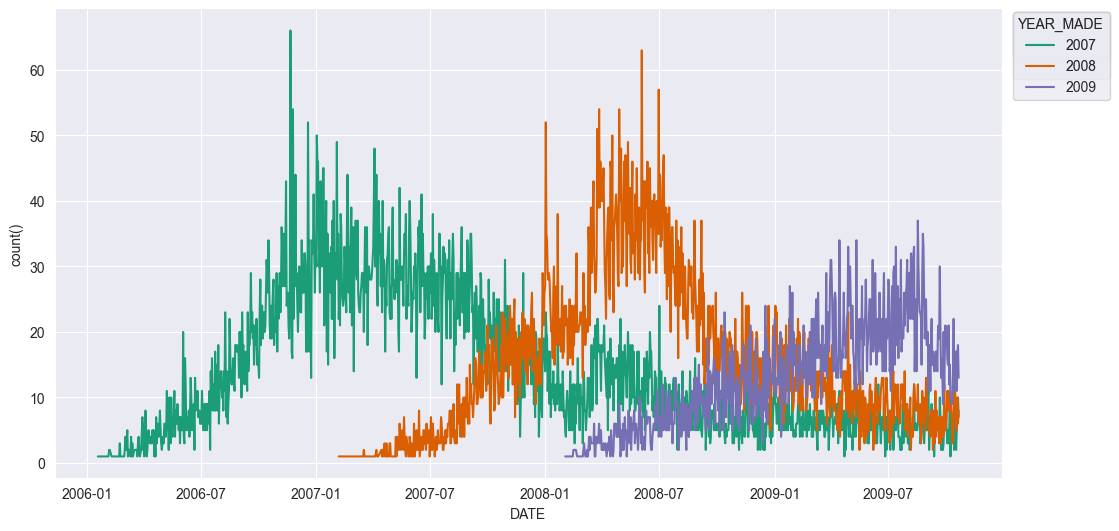

In [32]:
# @title DATE vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['DATE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'DATE'}, axis=1)
              .sort_values('DATE', ascending=True))
  xs = counted['DATE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = reviews_df.sort_values('DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('YEAR_MADE')):
  _plot_series(series, series_name, i)
  fig.legend(title='YEAR_MADE', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATE')
_ = plt.ylabel('count()')

In [33]:
def group_by_field(df, field, print_results=True):
    """
    Group reviews by the specified field and return the count for each group.

    Args:
        df (pd.DataFrame): DataFrame containing review data
        field (str): Field name to group by (e.g., 'YEAR', 'BRAND', 'MODEL', 'DATE')
        print_results (bool): Whether to print the results

    Returns:
        pd.Series: Count of reviews per group
    """
    if field not in df.columns:
        raise ValueError(f"Field '{field}' not found in DataFrame columns: {list(df.columns)}")

    counts = df.groupby(field).size()

    if print_results:
        print(f"Reviews per {field.lower()}:")
        print(counts)

    return counts

In [34]:
year_data = group_by_field(reviews_df, 'YEAR_MADE')
brand_data = group_by_field(reviews_df, 'BRAND')
model_data = group_by_field(reviews_df, 'MODEL')
date_data = group_by_field(reviews_df, 'DATE')

author_data = group_by_field(reviews_df, 'AUTHOR', print_results=True)

Reviews per year_made:
YEAR_MADE
2007    18903
2008    15438
2009     7947
dtype: int64
Reviews per brand:
BRAND
acura            1269
audi              637
bmw              1113
buick             504
cadillac          510
chevrolet        2864
chrysler          751
dodge            1682
ford             2775
gmc               831
honda            4570
hyundai          2502
infiniti          840
jeep             1189
kia               699
lexus             935
mazda            1819
mercedes-benz    1592
mini              196
mitsubishi        636
nissan           3003
pontiac          1086
saturn           1168
scion             700
smart             183
subaru           1015
suzuki            421
toyota           4720
volkswagen       1676
volvo             402
dtype: int64
Reviews per model:
MODEL
1_series         77
300              93
350z             58
370z             39
3_series        475
               ... 
yaris           589
yukon            98
yukon_hybrid     14
yukon_xl 

In [35]:
df = reviews_df
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[ \-]+", "_", regex=True)
      .str.replace(r"[^\w]", "", regex=True)
)

df

,date,author,text,favorite,model,brand,year_made
0,2009-05-12,Senor Oso,"This is a great car, performance with the spor...",Sport transmission and suspension along with 2...,x5,bmw,2008
1,2009-04-22,grizzy54,Since I bought this I've enjoyed it everyday. ...,Brakes dry automatically when it rains. Also h...,x5,bmw,2008
2,2009-04-13,City Engineer,"Bought brand new, June, 2008. Two months later...",Rear view camera,x5,bmw,2008
3,2009-04-02,Lt Dan,I'll make this blunt. I have had the car over ...,None of the features are WOW! For $65K I would...,x5,bmw,2008
4,2009-03-27,Jimmy,Bought X5 a year ago tomorrow and will be taki...,"Backup camera, voice recognition, comfortable ...",x5,bmw,2008
...,...,...,...,...,...,...,...
42283,2009-03-15,NCjp,I have waited to write this for a few months b...,Has space but looks sporty at the same time. A...,spectra,kia,2009
42284,2009-03-12,mholly99,I waited 5 months to write this review because...,"The fuel economy is great, the car looks nice,...",spectra,kia,2009
42285,2008-12-26,JoshUNC,After comparing prices on the '07 to the new '...,The price. Warranty. Great gas mileage. Sporty.,spectra,kia,2009
42286,2008-10-30,Derail,My previous car was an 03 Focus. The Spectra i...,"The price. The zippy acceleration, yet I get 3...",spectra,kia,2009


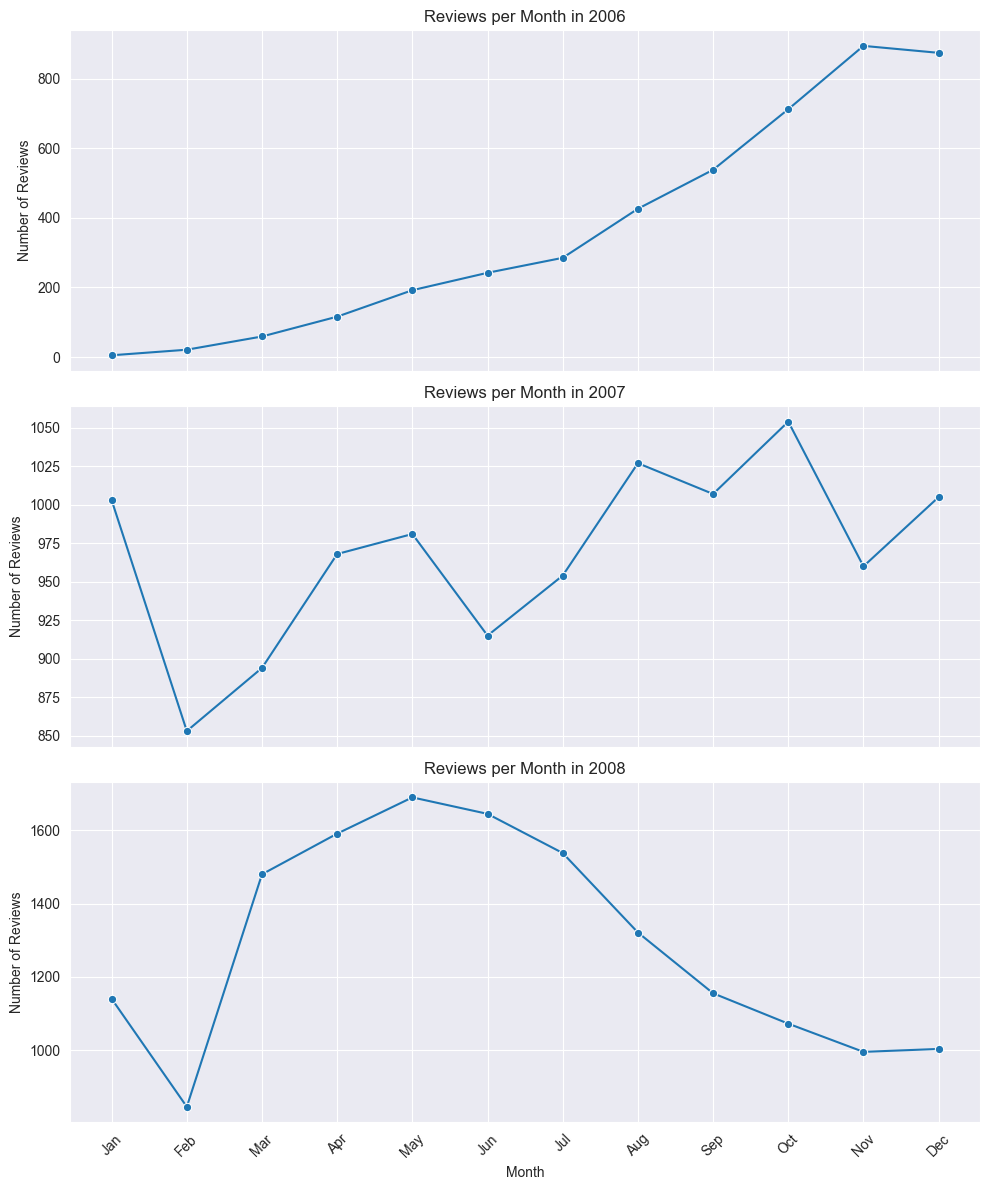

In [36]:
df['year_reviewed'] = df['date'].dt.year
df['month'] = df['date'].dt.month

counts = (
    df.groupby(['year_reviewed','month'])
      .size()
      .reset_index(name='n_reviews')
)

years = [2006, 2007, 2008, 2009, 2010] # изненадващо има ревюта и от 2006 - за коли от бъдещето...
fig, axes = plt.subplots(
    nrows=3, ncols=1,
    figsize=(10, 12),
    sharex=True
)

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for ax, year in zip(axes, years):
    data = counts[counts['year_reviewed'] == year]
    sns.lineplot(
        data=data,
        x='month', y='n_reviews',
        marker='o',
        ax=ax
    )
    ax.set_title(f'Reviews per Month in {year}')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(month_names, rotation=45)
    ax.set_ylabel('Number of Reviews')

axes[-1].set_xlabel('Month')

plt.tight_layout()
plt.show()

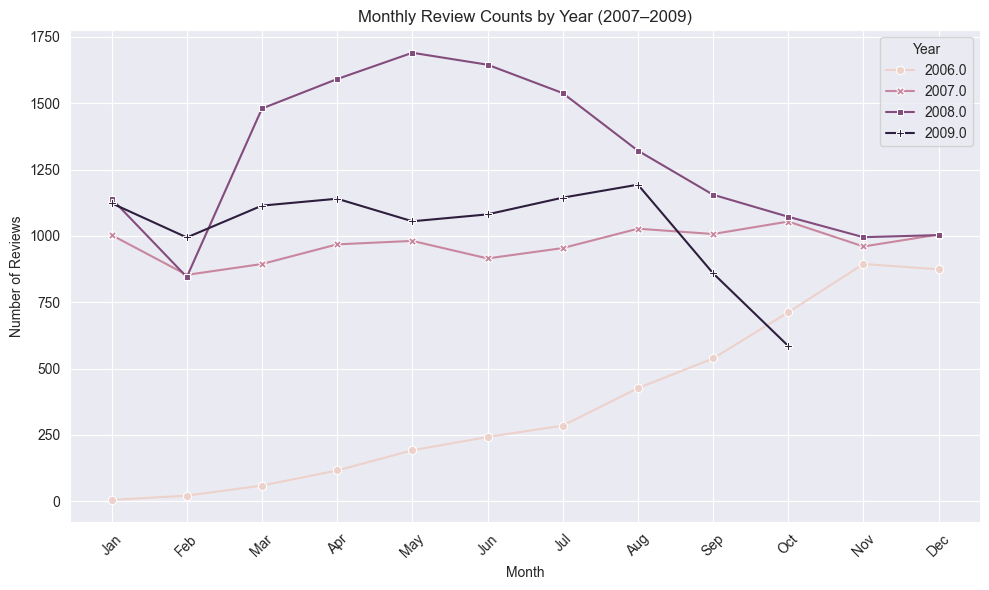

In [37]:
counts = (
    df.groupby(['year_reviewed','month']) 
      .size()
      .reset_index(name='n_reviews')
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=counts,
    x='month', y='n_reviews',
    hue='year_reviewed', 
    style='year_reviewed', 
    markers=True,
    dashes=False
)

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks=range(1,13), labels=month_names, rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Review Counts by Year (2007–2009)')
plt.legend(title='Year')
plt.tight_layout()
plt.show()
#interestingly we have reviews for cars of the future - their date is before the car manufacture date. Probably insider info or misconfigured server time.

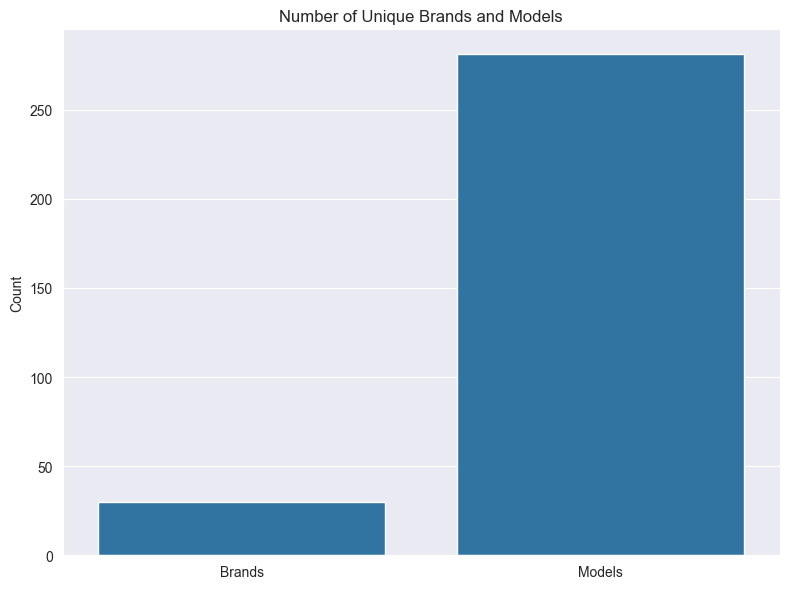

In [38]:
brand_count = df['brand'].nunique()
model_count = df['model'].nunique()

categories = ['Brands', 'Models']
counts = [brand_count, model_count]

plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=counts)
plt.title('Number of Unique Brands and Models')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

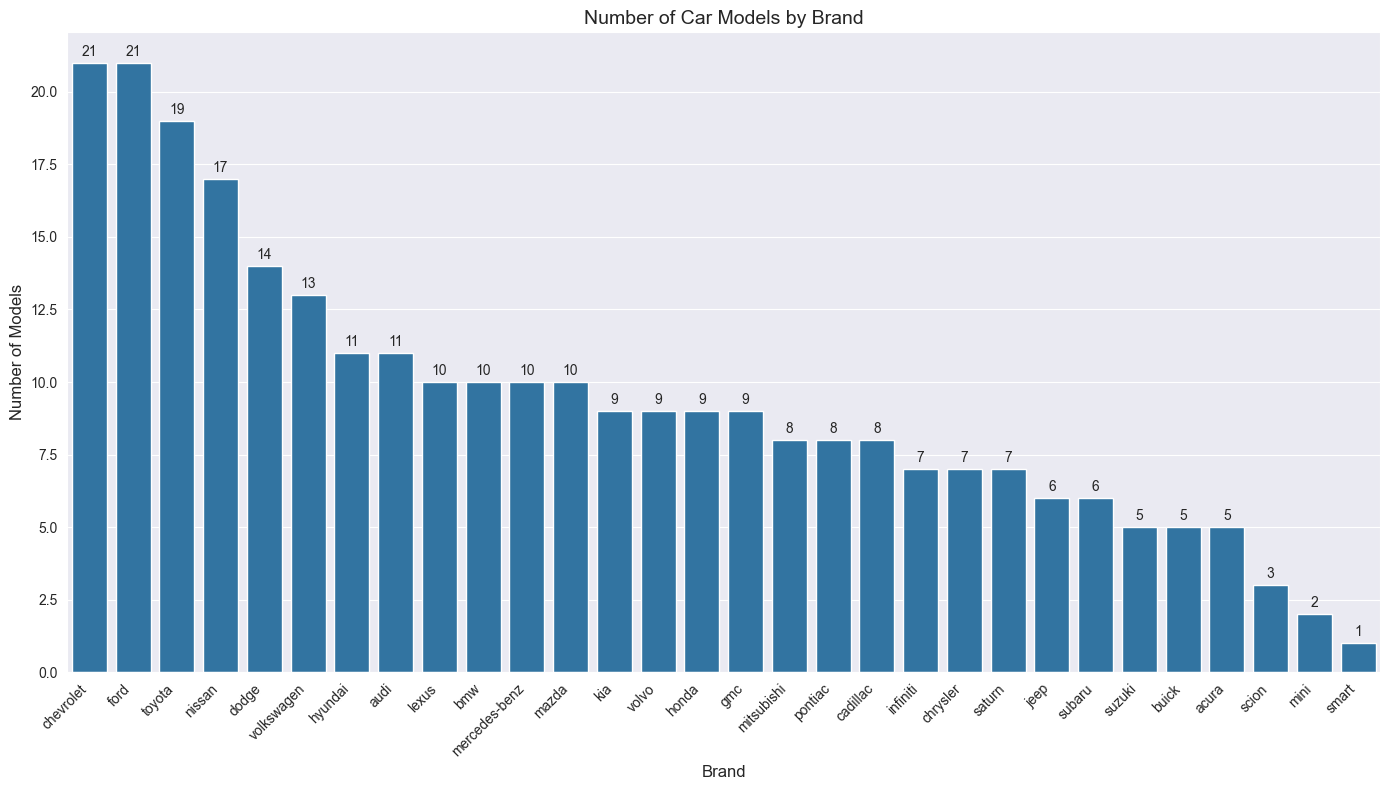

In [39]:
models_by_brand = df.groupby('brand')['model'].nunique().reset_index()
models_by_brand.columns = ['Brand', 'Number of Models']

models_by_brand = models_by_brand.sort_values('Number of Models', ascending=False)

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=models_by_brand, x='Brand', y='Number of Models')

plt.title('Number of Car Models by Brand', fontsize=14)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Number of Models', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, bar in enumerate(ax.patches):
    count = models_by_brand.iloc[i]['Number of Models']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

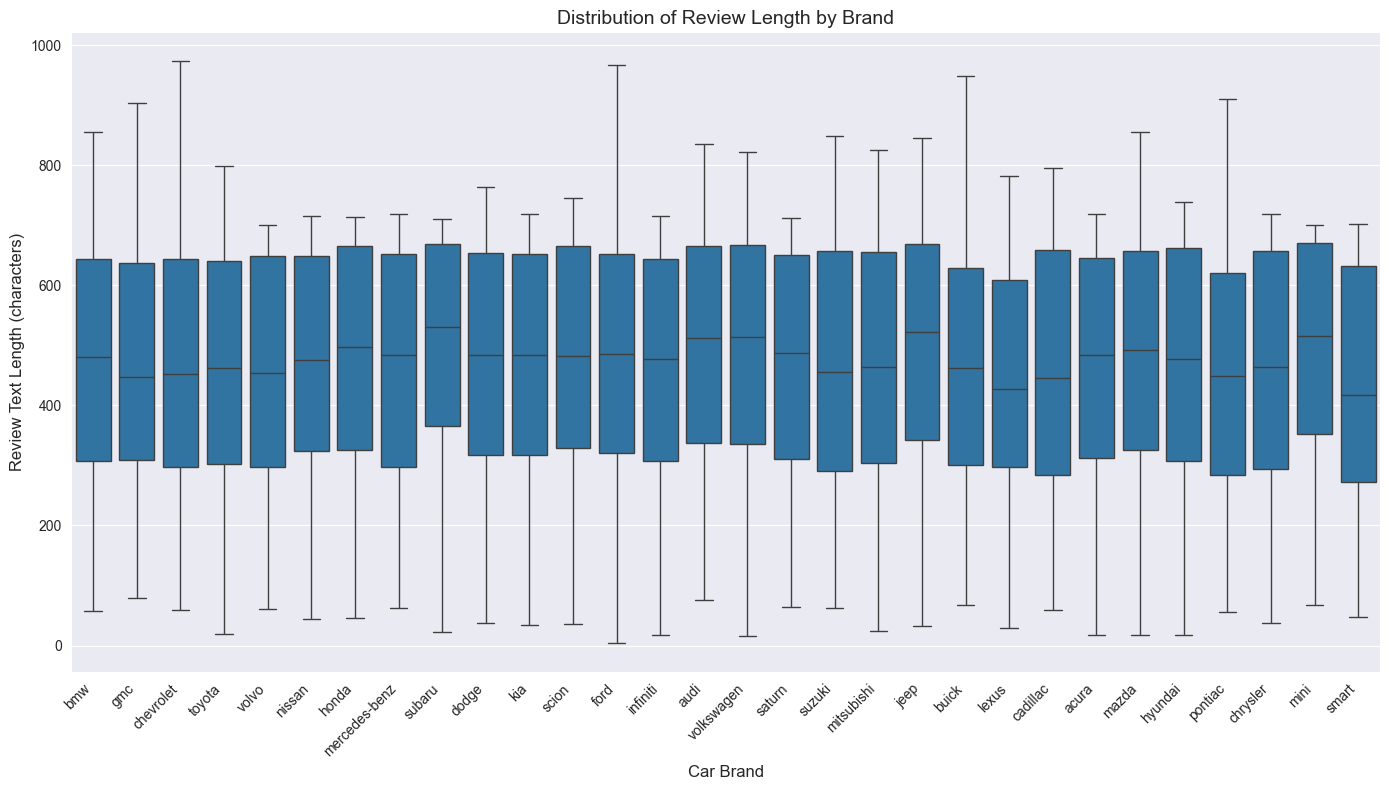

In [40]:
df['text_len'] = df['text'].str.len()

plt.figure(figsize=(14, 8))

ax = sns.boxplot(data=df, x='brand', y='text_len')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Car Brand', fontsize=12)
plt.ylabel('Review Text Length (characters)', fontsize=12)
plt.title("Distribution of Review Length by Brand", fontsize=14)

plt.subplots_adjust(bottom=0.2)

plt.tight_layout()

plt.show()
# Subaru reviews are - longest on average because Japanese cars are most appreciated by their owners. Not biased opinion (at all :))

In [41]:
null_rows = df[df.isna().any(axis=1)]
print(f"Number of rows with null values: {len(null_rows)}")
display(null_rows)

empty_text_rows = df[(df['text'] == '') |
                     (df['author'] == '') |
                     (df['favorite'] == '')]
print(f"Number of rows with empty text fields: {len(empty_text_rows)}")
display(empty_text_rows)

Number of rows with null values: 540


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
325,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
326,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
327,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
328,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
329,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
860,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
861,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
862,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
863,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN


Number of rows with empty text fields: 1631


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
41,2008-03-21,unhappy Jess,"Start with my X5 has only 3500 miles in it, at...",,x5,bmw,2008,2008.0,3.0,337.0
63,2009-07-09,DT,They just keep getting better. I had a Tahoe a...,,suburban,chevrolet,2008,2009.0,7.0,501.0
158,2007-12-10,retired_newmex,Fantastic truck. Lo-4 a little tricky to engag...,,tacoma,toyota,2008,2007.0,12.0,57.0
165,2007-09-28,jay,The best truck on the market. The ride is amaz...,,tacoma,toyota,2008,2007.0,9.0,354.0
185,2009-07-24,Hatchback,I expected more from a nissan. It has been in ...,,versa,nissan,2008,2009.0,7.0,382.0
...,...,...,...,...,...,...,...,...,...,...
42101,2009-04-18,sketchbone,Bought a black 1LT manual earlier today and I'...,,corvette,chevrolet,2009,2009.0,4.0,694.0
42117,2009-09-25,Becky,Love my new Murano! I got the S AWD with the c...,,murano,nissan,2009,2009.0,9.0,242.0
42222,2009-03-02,Lillie,I noticed in some old entries that Wind noise ...,,murano,nissan,2009,2009.0,3.0,337.0
42255,2008-09-16,goodday,Traded in a Quest van. Nissan really ramped up...,,murano,nissan,2009,2008.0,9.0,331.0


In [42]:
date_missing = df[df['date'].isna()]
print(f"Number of rows with missing dates: {len(date_missing)}")
display(date_missing)

df_filtered = df.dropna(subset=['date'])
print(f"Original dataframe shape: {df.shape}")
print(f"Filtered dataframe shape: {df_filtered.shape}")
print(f"Removed {df.shape[0] - df_filtered.shape[0]} rows with missing dates")

Number of rows with missing dates: 540


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
325,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
326,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
327,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
328,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
329,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
860,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
861,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
862,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
863,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN


Original dataframe shape: (42288, 10)
Filtered dataframe shape: (41748, 10)
Removed 540 rows with missing dates


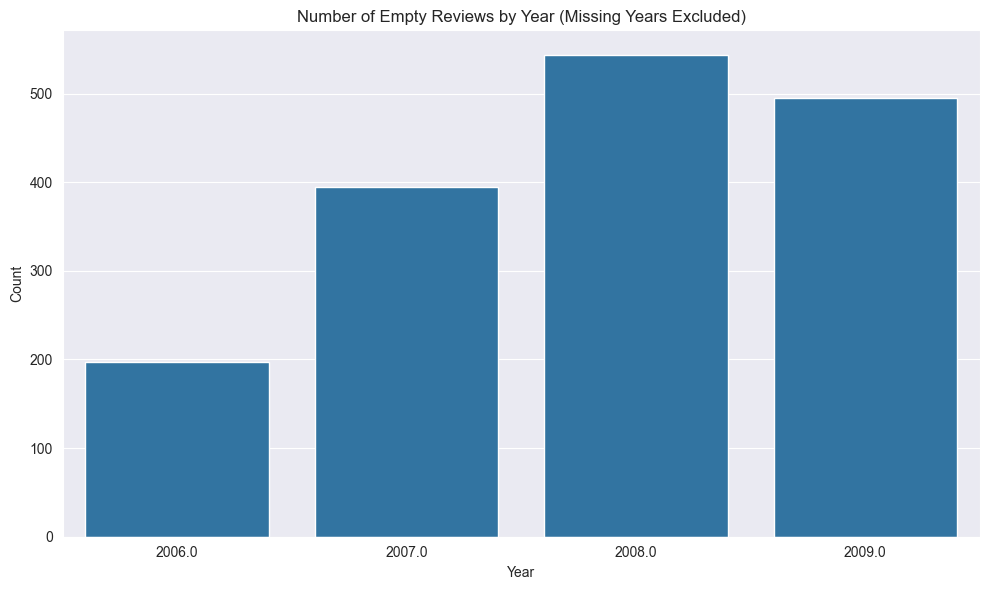

In [44]:
empty_reviews = df[(df.isna().any(axis=1)) |
                   (df['text'] == '') |
                   (df['author'] == '') |
                   (df['favorite'] == '')]

empty_reviews_filtered = empty_reviews.dropna(subset=['year_reviewed']).copy()

empty_by_year = empty_reviews_filtered.groupby('year_reviewed').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=empty_by_year, x='year_reviewed', y='count')
plt.title('Number of Empty Reviews by Year (Missing Years Excluded)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Average reviews per day: 31.04


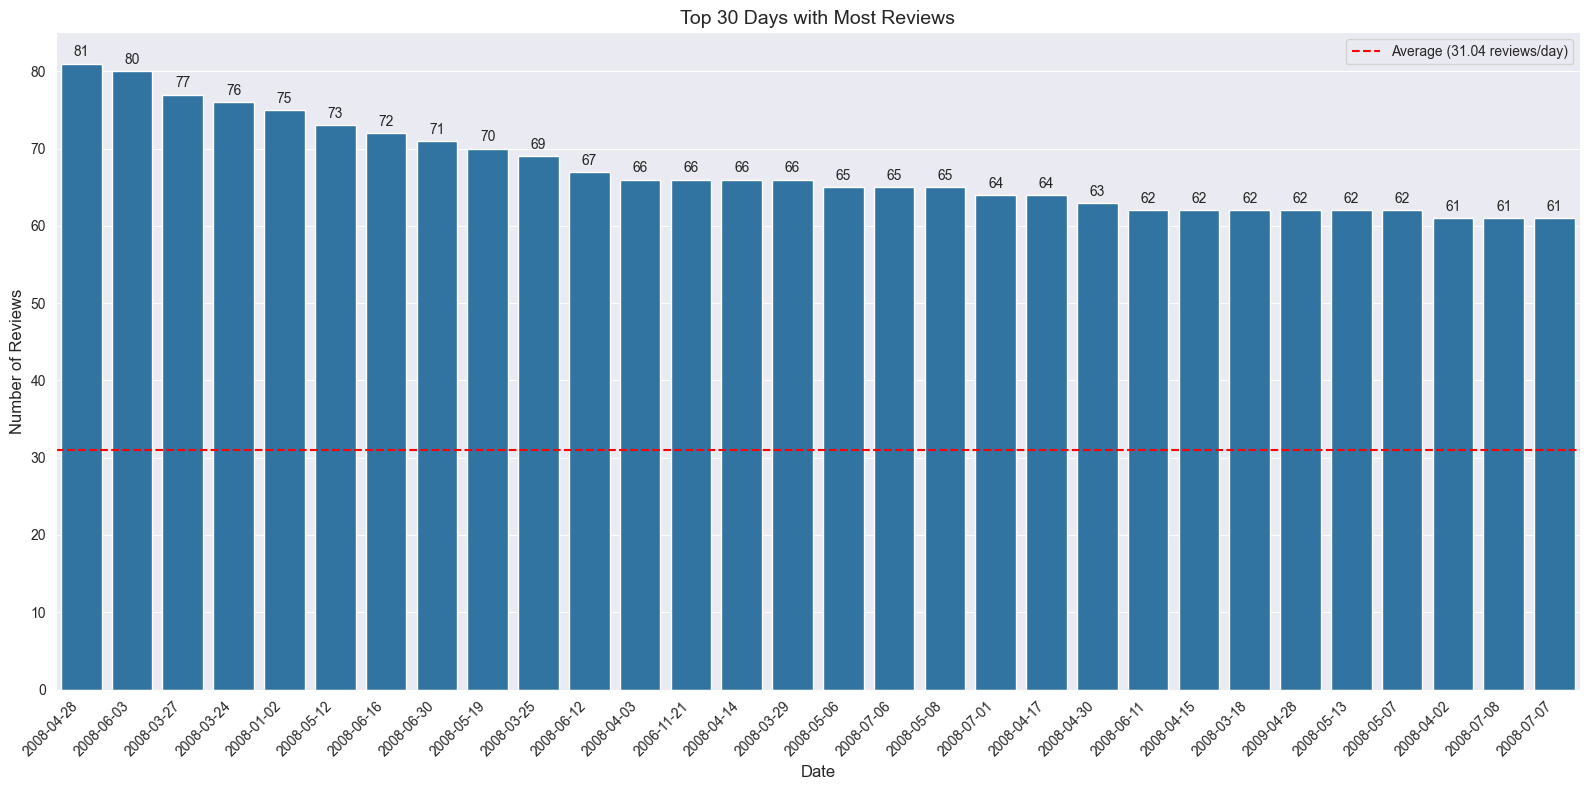

In [45]:
reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

avg_reviews_per_day = reviews_per_day['reviews'].mean()
print(f"Average reviews per day: {avg_reviews_per_day:.2f}")


top_30_days = reviews_per_day.sort_values('reviews', ascending=False).head(30)

plt.figure(figsize=(16, 8))  # Larger figure to fit more bars
ax = sns.barplot(data=top_30_days, x='date', y='reviews')

ax.axhline(y=avg_reviews_per_day, color='r', linestyle='--',
           label=f'Average ({avg_reviews_per_day:.2f} reviews/day)')


plt.title('Top 30 Days with Most Reviews', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()

for i, bar in enumerate(ax.patches):
    count = top_30_days.iloc[i]['reviews']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

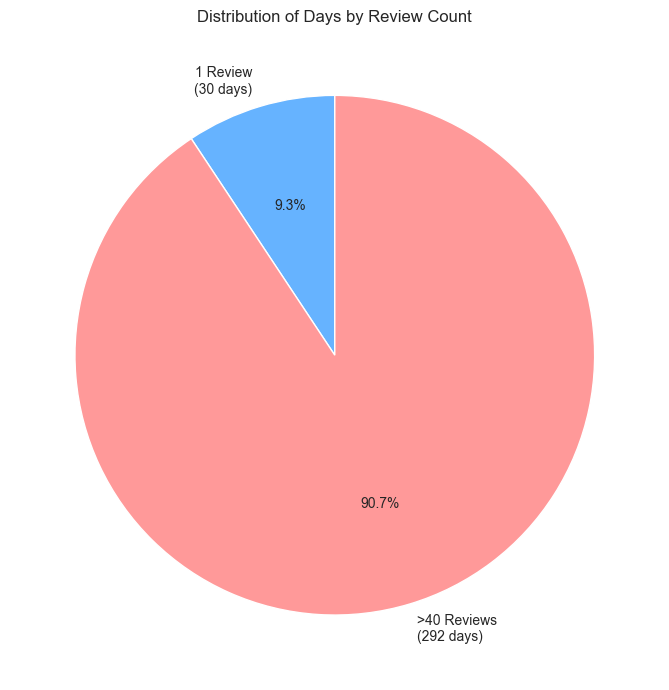

In [46]:

reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

days_with_1_review = (reviews_per_day['reviews'] == 1).sum()
days_with_over_40_reviews = (reviews_per_day['reviews'] > 40).sum()

categories = ['1 Review', '>40 Reviews']
counts = [days_with_1_review, days_with_over_40_reviews]

plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=[f"{cat}\n({cnt} days)" for cat, cnt in zip(categories, counts)],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999']
)
plt.title('Distribution of Days by Review Count')
plt.tight_layout()
plt.show()

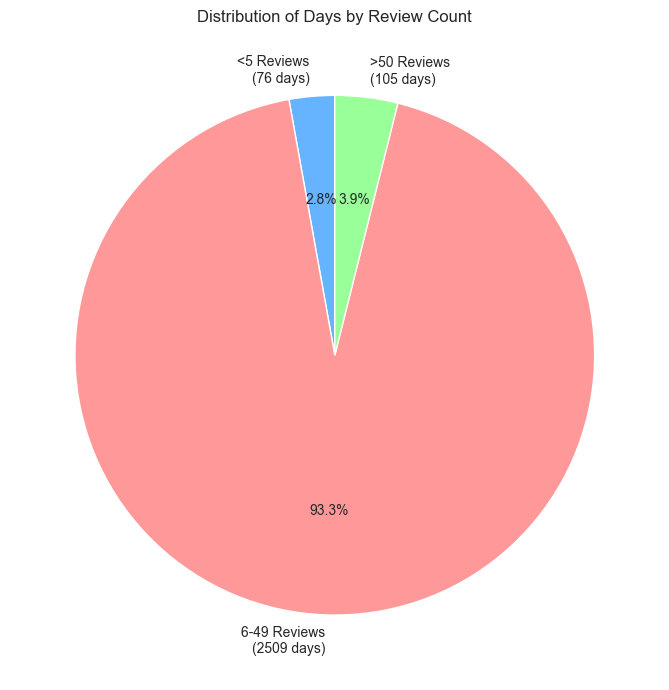

In [47]:

reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

days_with_1_review = (reviews_per_day['reviews'] < 5).sum()
days_in_between = (reviews_per_day['reviews'] >= 5).sum() + (reviews_per_day['reviews'] <= 50).sum()
days_with_over_40_reviews = (reviews_per_day['reviews'] > 50).sum()

categories = ['<5 Reviews', '6-49 Reviews', '>50 Reviews']
counts = [days_with_1_review, days_in_between, days_with_over_40_reviews]

plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=[f"{cat}\n({cnt} days)" for cat, cnt in zip(categories, counts)],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999', '#99ff99']
)
plt.title('Distribution of Days by Review Count')
plt.tight_layout()
plt.show()

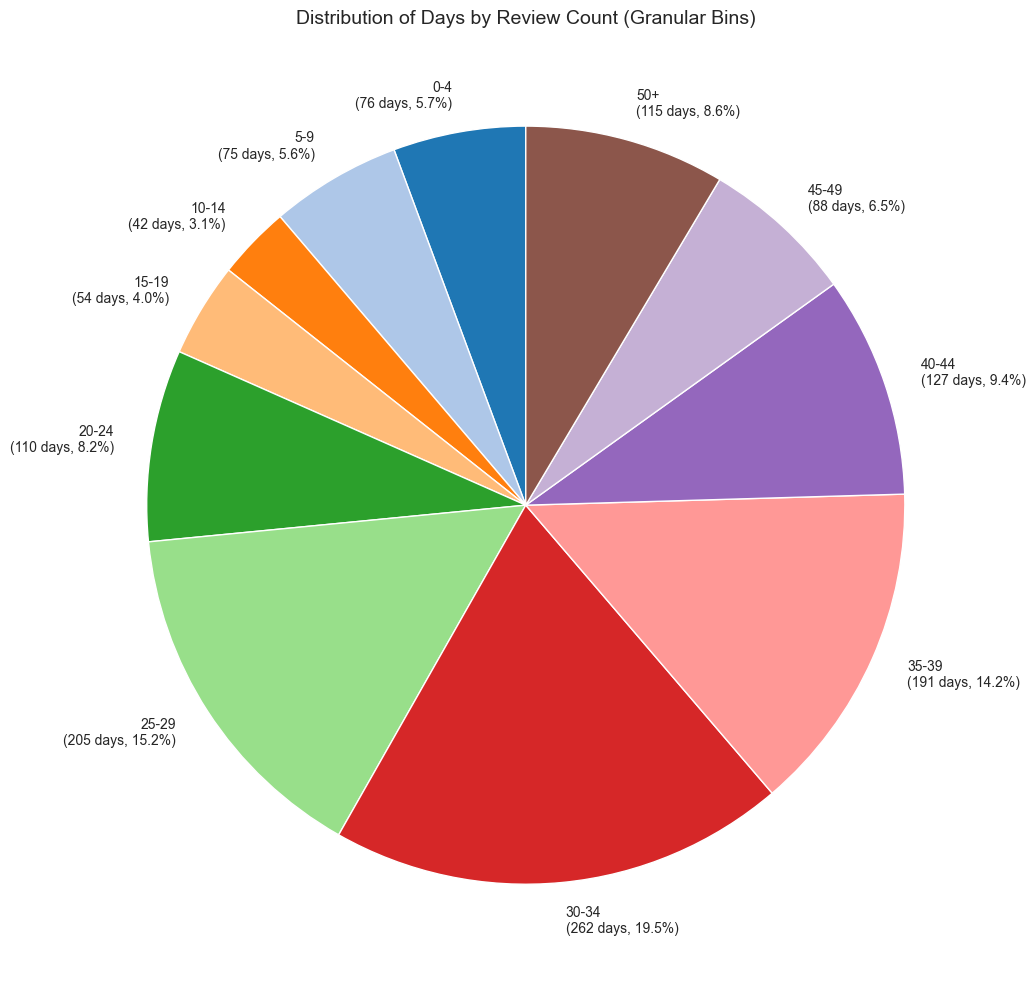

Distribution of days by review count:
0-4 reviews: 76 days (5.7%)
5-9 reviews: 75 days (5.6%)
10-14 reviews: 42 days (3.1%)
15-19 reviews: 54 days (4.0%)
20-24 reviews: 110 days (8.2%)
25-29 reviews: 205 days (15.2%)
30-34 reviews: 262 days (19.5%)
35-39 reviews: 191 days (14.2%)
40-44 reviews: 127 days (9.4%)
45-49 reviews: 88 days (6.5%)
50+ reviews: 115 days (8.6%)


In [48]:
reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

bins = [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, float('inf')]
bin_labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50+']

binned_reviews = pd.cut(reviews_per_day['reviews'], bins=bins, labels=bin_labels, right=True)
day_counts = binned_reviews.value_counts().sort_index()

pie_data = pd.DataFrame({'bin': day_counts.index, 'count': day_counts.values})

total_days = pie_data['count'].sum()
pie_data['percentage'] = (pie_data['count'] / total_days * 100).round(1)

pie_data['label'] = pie_data.apply(
    lambda x: f"{x['bin']}\n({x['count']} days, {x['percentage']}%)",
    axis=1
)

plt.figure(figsize=(12, 10))
plt.pie(
    pie_data['count'],
    labels=pie_data['label'],
    autopct='',  # Using custom labels instead
    startangle=90,
    colors=plt.cm.tab20.colors[:len(pie_data)]
)
plt.title('Distribution of Days by Review Count (Granular Bins)', fontsize=14)
plt.tight_layout()
plt.show()

# Display the actual counts in a table
print("Distribution of days by review count:")
for idx, row in pie_data.iterrows():
    print(f"{row['bin']} reviews: {row['count']} days ({row['percentage']}%)")


Top 6 brands by review count: ['toyota', 'honda', 'nissan', 'chevrolet', 'ford', 'hyundai']


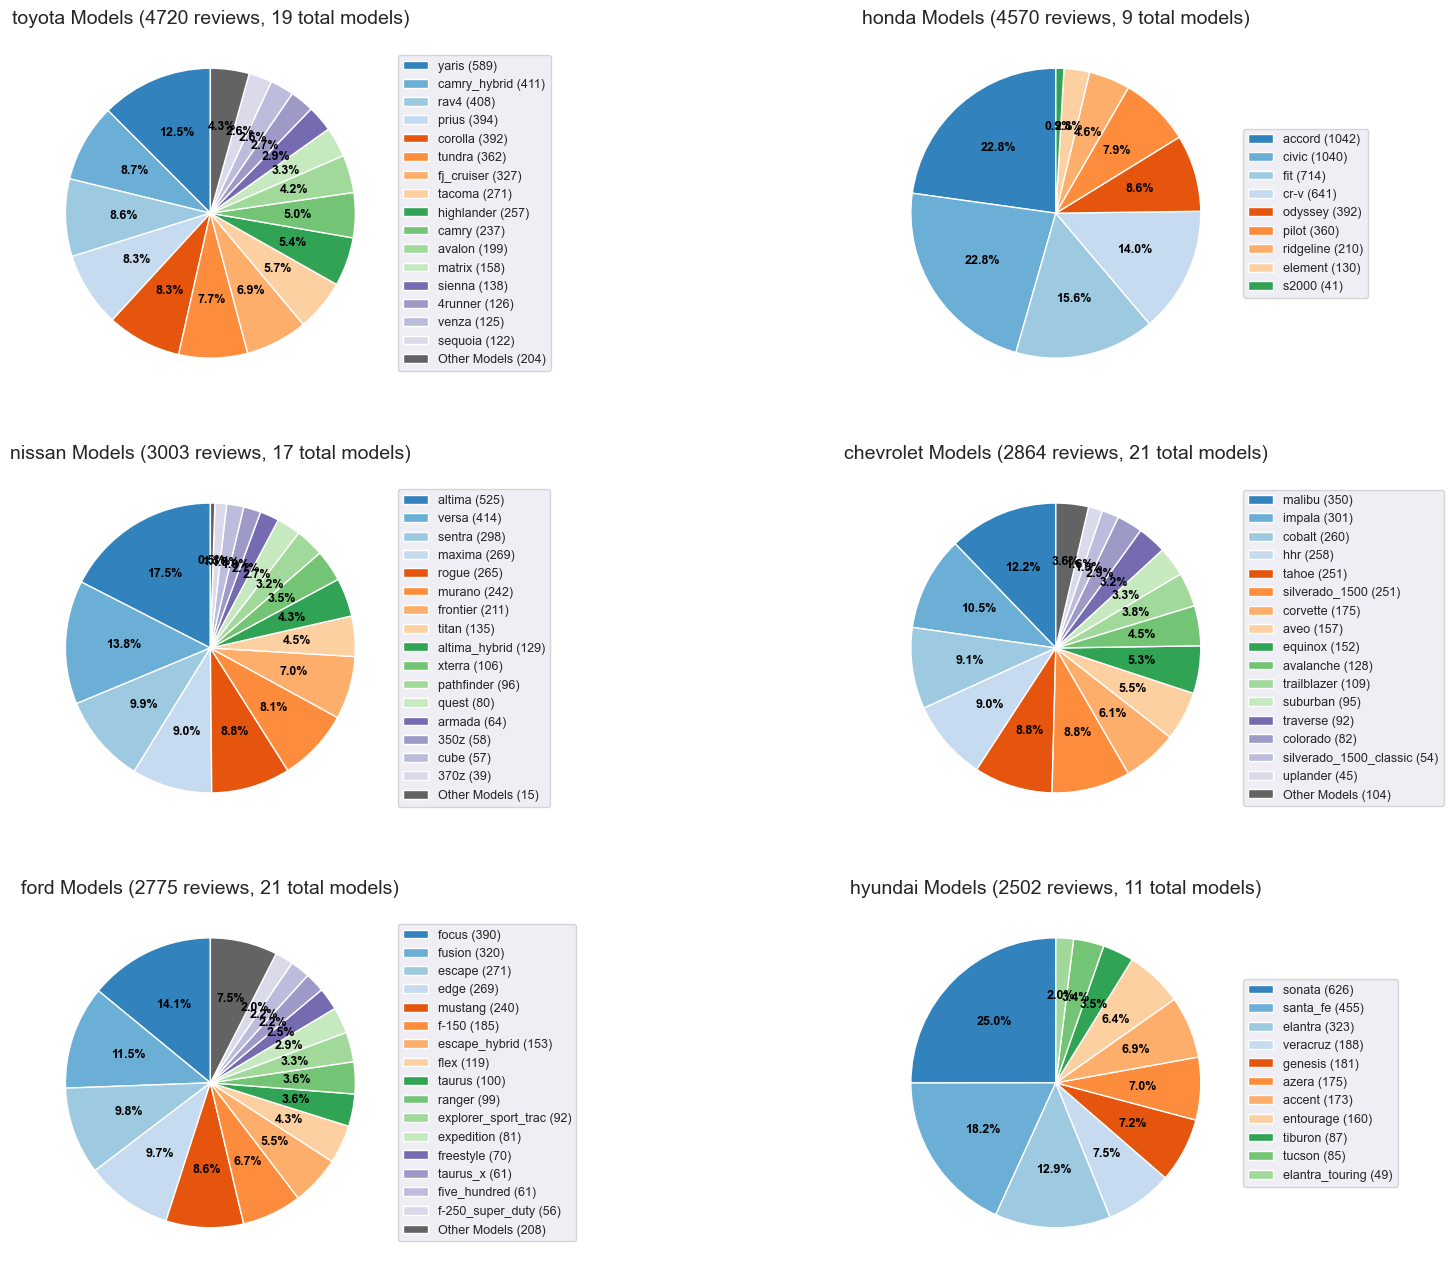

In [49]:
top_brands = df['brand'].value_counts().head(6).index.tolist()
print(f"Top 6 brands by review count: {top_brands}")

fig, axes = plt.subplots(3, 2, figsize=(20, 16))
axes = axes.flatten()  # Flatten for easier iteration

for i, brand in enumerate(top_brands):
    brand_data = df[df['brand'] == brand]

    model_counts = brand_data['model'].value_counts()
    total_reviews = model_counts.sum()
    num_models = len(model_counts)

    N = 16
    if len(model_counts) > N:
        top_models = model_counts.head(N)
        other_count = model_counts[N:].sum()
        plot_data = pd.concat([top_models, pd.Series({'Other Models': other_count})])
    else:
        plot_data = model_counts

    ax = axes[i]
    wedges, texts, autotexts = ax.pie(
        plot_data.values,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab20c.colors[:len(plot_data)],
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)

    ax.set_title(f'{brand} Models ({total_reviews} reviews, {num_models} total models)', fontsize=14)

    legend_labels = [f"{model} ({count})" for model, count in zip(plot_data.index, plot_data.values)]
    ax.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

plt.show()


Number of unique favorites: 38571

Top favorites and their counts:


,Favorite,Count
0,,1631
1,Suggested Improvements,69
2,Everything,61
3,None,44
4,Everything.,31
5,Everything!,28
6,Gas mileage,27
7,none,22
8,Written by:,17
9,everything,16


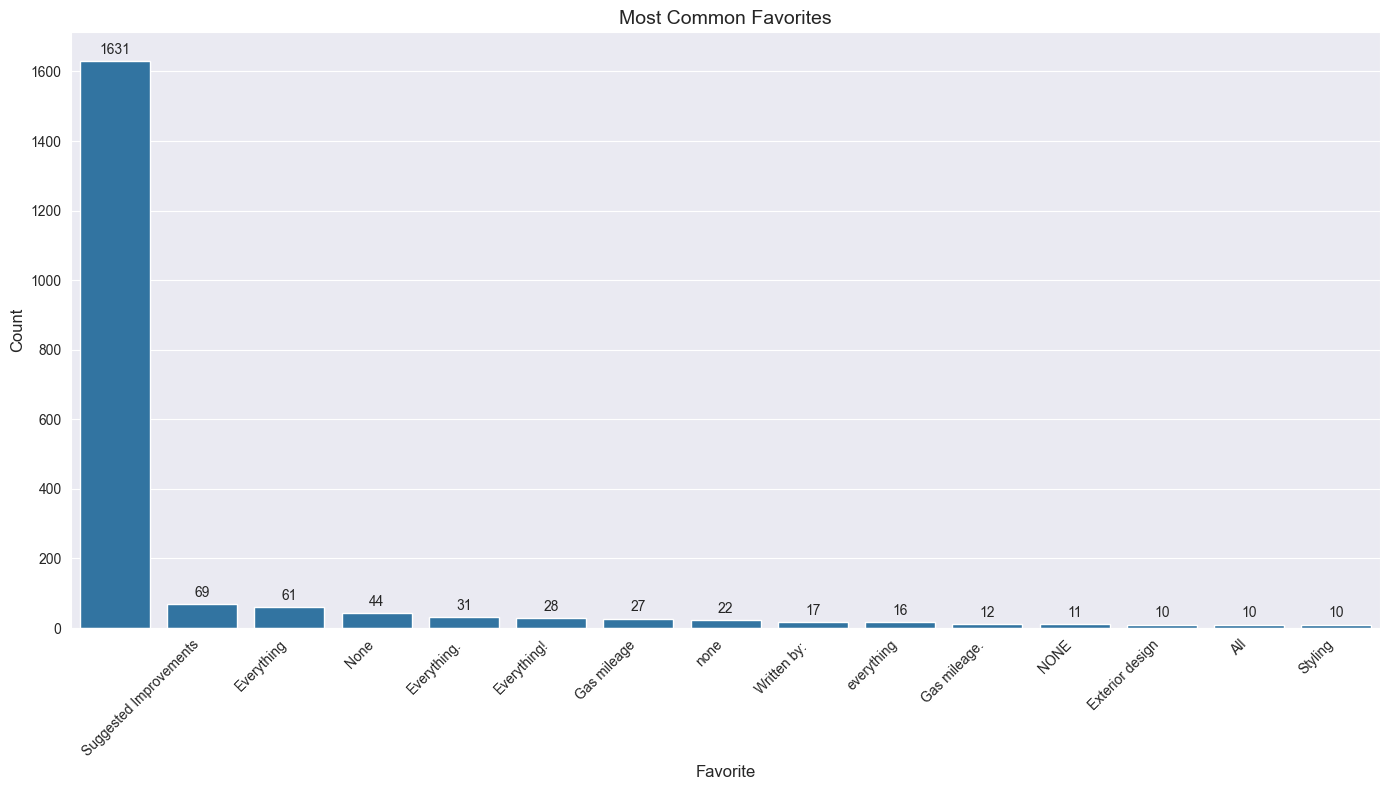

In [50]:
unique_favorites_count = df['favorite'].nunique()
print(f"Number of unique favorites: {unique_favorites_count}")

favorite_counts = df['favorite'].value_counts().reset_index()
favorite_counts.columns = ['Favorite', 'Count']

print("\nTop favorites and their counts:")
display(favorite_counts.head(10))  # Show top 10 favorites

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=favorite_counts.head(15), x='Favorite', y='Count')
plt.title('Most Common Favorites', fontsize=14)
plt.xlabel('Favorite', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, bar in enumerate(ax.patches):
    count = favorite_counts.iloc[i]['Count']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_2516/377681255.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=most_reviewed, x='model', y='count', ax=axes[0], palette='viridis')
/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_2516/377681255.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=least_reviewed, x='model', y='count', ax=axes[1], palette='magma')


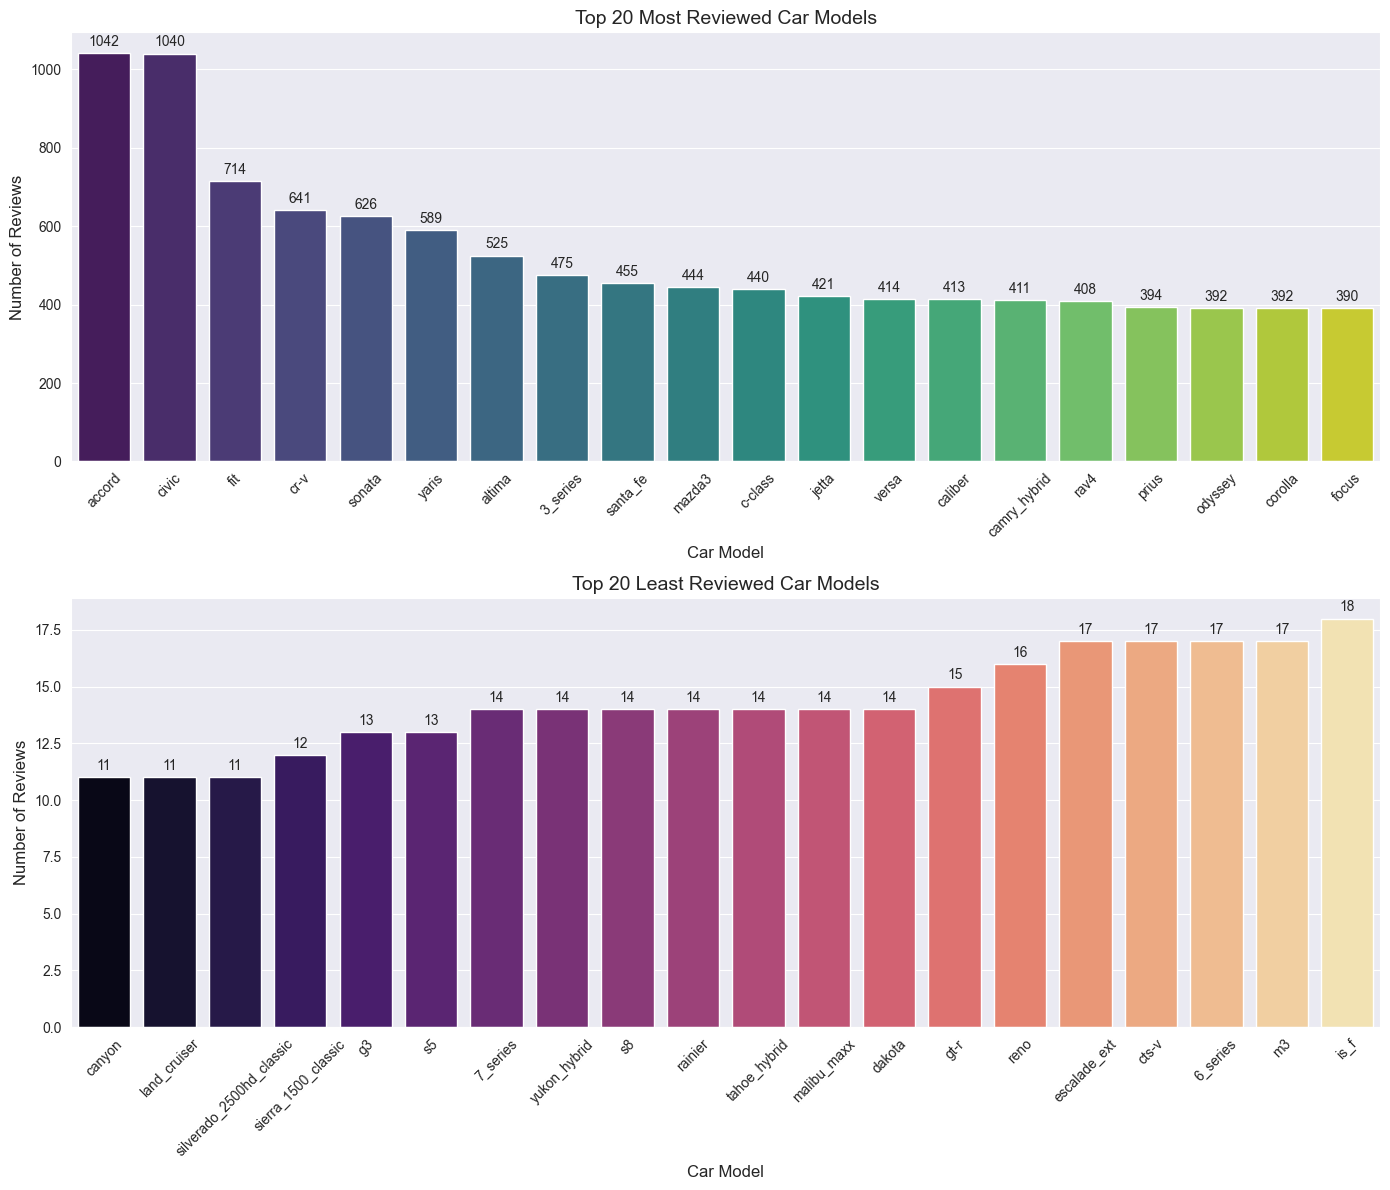

In [51]:
model_review_counts = df.groupby('model').size().reset_index(name='count')

most_reviewed = model_review_counts.sort_values('count', ascending=False).head(20)
least_reviewed = model_review_counts.sort_values('count').head(20)

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

sns.barplot(data=most_reviewed, x='model', y='count', ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Most Reviewed Car Models', fontsize=14)
axes[0].set_xlabel('Car Model', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

for i, bar in enumerate(axes[0].patches):
    count = most_reviewed.iloc[i]['count']
    axes[0].annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

sns.barplot(data=least_reviewed, x='model', y='count', ax=axes[1], palette='magma')
axes[1].set_title('Top 20 Least Reviewed Car Models', fontsize=14)
axes[1].set_xlabel('Car Model', fontsize=12)
axes[1].set_ylabel('Number of Reviews', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

for i, bar in enumerate(axes[1].patches):
    count = least_reviewed.iloc[i]['count']
    axes[1].annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [52]:
model_counts = df.groupby('model').size().sort_values(ascending=False)
print("Unique Car Models with Review Counts:")
print("====================================")
for model, count in model_counts.items():
    print(f"{model}: {count}")

print(f"\nTotal unique models: {len(model_counts)}")

Unique Car Models with Review Counts:
accord: 1042
civic: 1040
fit: 714
cr-v: 641
sonata: 626
yaris: 589
altima: 525
3_series: 475
santa_fe: 455
mazda3: 444
c-class: 440
jetta: 421
versa: 414
caliber: 413
camry_hybrid: 411
rav4: 408
prius: 394
odyssey: 392
corolla: 392
focus: 390
acadia: 388
tl: 371
tundra: 362
pilot: 360
malibu: 350
aura: 331
cx-7: 331
wrangler: 327
fj_cruiser: 327
elantra: 323
g35: 320
fusion: 320
mdx: 315
impala: 301
sentra: 298
vue: 296
g6: 286
xb: 275
escape: 271
tacoma: 271
maxima: 269
edge: 269
patriot: 267
tsx: 266
cx-9: 265
impreza: 265
rogue: 265
rdx: 263
cobalt: 260
forester: 260
enclave: 259
passat: 259
mazda6: 258
hhr: 258
highlander: 257
silverado_1500: 251
tahoe: 251
rabbit: 242
e-class: 242
murano: 242
mustang: 240
5_series: 239
camry: 237
g8: 236
tc: 232
es_350: 226
a4: 223
m-class: 222
outlander: 222
cts: 219
gl-class: 214
frontier: 211
ridgeline: 210
ram_pickup_1500: 209
town_and_country: 207
outlook: 206
avalon: 199
outback: 198
xd: 193
mazda5: 191


In [56]:
import re
import nltk
import string
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
vader = SentimentIntensityAnalyzer()


def clean_text(text):
    """Clean and normalize text data."""
    if not isinstance(text, str) or pd.isna(text):
        return ""

    text = text.lower()

    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def preprocess_text(text):
    """Tokenize, remove stopwords, and lemmatize text."""
    if not text:
        return []

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens


def extract_features(row):
    """Extract features from text fields."""
    text = clean_text(row['text']) if isinstance(row['text'], str) else ""
    favorite = clean_text(row['favorite']) if isinstance(row['favorite'], str) else ""

    text_length = len(text)
    text_word_count = len(text.split()) if text else 0

    processed_tokens = preprocess_text(text)

    vader_scores = vader.polarity_scores(text) if text else {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

    tb = TextBlob(text)
    tb_polarity = tb.sentiment.polarity if text else 0
    tb_subjectivity = tb.sentiment.subjectivity if text else 0

    has_price_mention = 1 if re.search(r'price|cost|expensive|cheap|afford', text) else 0
    has_performance_mention = 1 if re.search(r'speed|fast|slow|acceleration|horsepower|hp|mpg', text) else 0
    has_comfort_mention = 1 if re.search(r'comfort|seat|space|room|leg|interior', text) else 0
    has_reliability_mention = 1 if re.search(r'reliable|dependable|quality|problem|issue|break', text) else 0

    return {
        'text_length': text_length,
        'word_count': text_word_count,
        'vader_negative': vader_scores['neg'],
        'vader_neutral': vader_scores['neu'],
        'vader_positive': vader_scores['pos'],
        'vader_compound': vader_scores['compound'],
        'textblob_polarity': tb_polarity,
        'textblob_subjectivity': tb_subjectivity,
        'has_price_mention': has_price_mention,
        'has_performance_mention': has_performance_mention,
        'has_comfort_mention': has_comfort_mention,
        'has_reliability_mention': has_reliability_mention,
        'cleaned_text': ' '.join(processed_tokens)
    }

[nltk_data] Downloading package punkt to /Users/tsvetan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tsvetan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tsvetan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tsvetan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Enriched DataFrame with text features:

Sentiment Analysis Statistics:
       vader_compound  textblob_polarity  textblob_subjectivity
count    42288.000000       42288.000000           42288.000000
mean         0.697473           0.240383               0.524715
std          0.476069           0.174218               0.133011
min         -0.992000          -1.000000               0.000000
25%          0.717200           0.137396               0.454859
50%          0.911700           0.243242               0.528175
75%          0.963200           0.345844               0.602246
max          0.997700           1.000000               1.000000


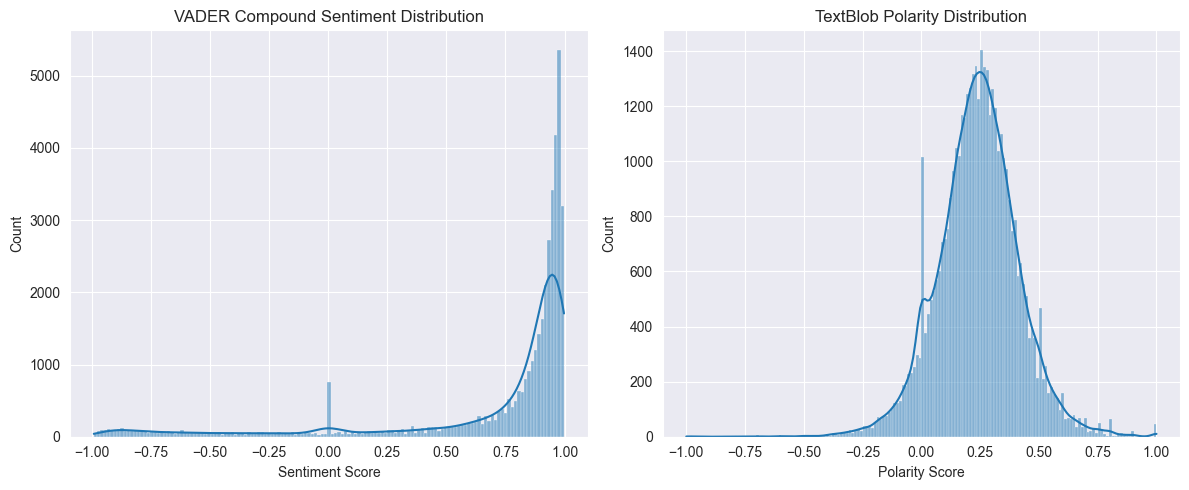

In [57]:
feature_data = df.apply(extract_features, axis=1)

features_df = pd.DataFrame(feature_data.tolist())

df_enriched = pd.concat([df, features_df], axis=1)

print("Enriched DataFrame with text features:")
var = df_enriched.sample(5)[['model', 'brand', 'text_length', 'word_count',
                             'vader_compound', 'textblob_polarity', 'has_performance_mention']]

print("\nSentiment Analysis Statistics:")
print(df_enriched[['vader_compound', 'textblob_polarity', 'textblob_subjectivity']].describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_enriched['vader_compound'], kde=True)
plt.title('VADER Compound Sentiment Distribution')
plt.xlabel('Sentiment Score')

plt.subplot(1, 2, 2)
sns.histplot(df_enriched['textblob_polarity'], kde=True)
plt.title('TextBlob Polarity Distribution')
plt.xlabel('Polarity Score')

plt.tight_layout()
plt.show()

Distribution of sentiment labels:
sentiment_label
positive    37065
negative     3867
neutral      1356
Name: count, dtype: int64


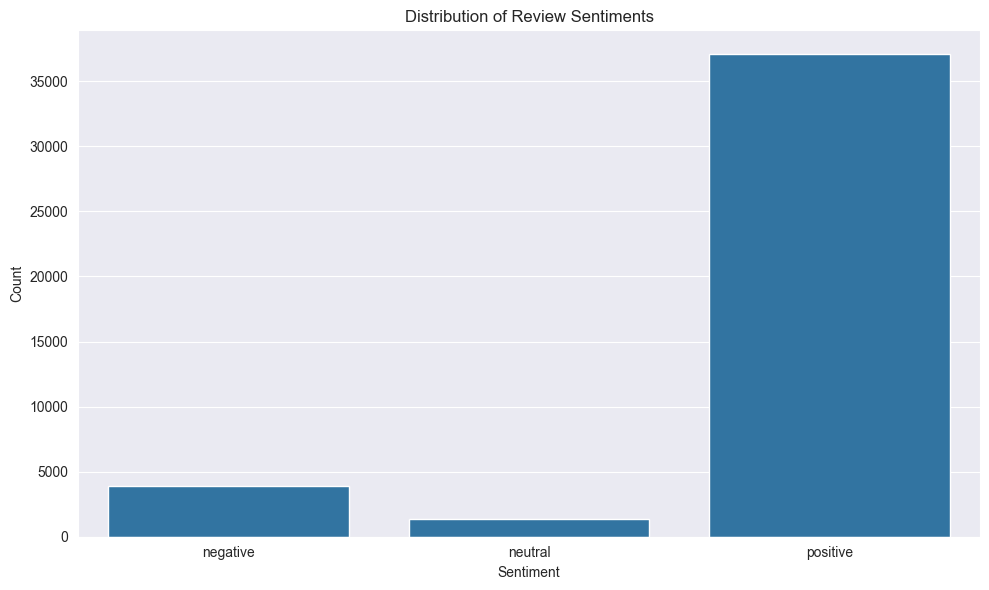

Training set size: 33398
Testing set size: 8350


In [58]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import numpy as np

df_enriched['sentiment_label'] = pd.cut(
    df_enriched['vader_compound'],
    bins=[-1, -0.1, 0.1, 1],
    labels=['negative', 'neutral', 'positive']
)

sentiment_distribution = df_enriched['sentiment_label'].value_counts()
print("Distribution of sentiment labels:")
print(sentiment_distribution)

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=df_enriched)
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

X = df_enriched['cleaned_text']
y = df_enriched['sentiment_label']

valid_indices = ~X.isna() & (X != '')
X = X[valid_indices]
y = y[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

In [74]:
# !pip install --upgrade pandas
# !pip install  gensim
!pip install  numpy>1.22

In [78]:
import numpy as np
import pandas as pd
import os
import requests
import zipfile
import io
from tqdm.auto import tqdm

# Download pre-trained GloVe embeddings
def download_glove(dimension=100):
    if not os.path.exists('glove'):
        os.makedirs('glove')

    file_path = f'glove/glove.6B.{dimension}d.txt'
    if not os.path.exists(file_path):
        print("Downloading GloVe embeddings...")
        r = requests.get('https://nlp.stanford.edu/data/glove.6B.zip', verify=False)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall('glove')
        print("Download complete.")
    else:
        print(f"Using existing GloVe embeddings: {file_path}")

    return file_path

# Load GloVe embeddings into a dictionary
def load_glove_embeddings(file_path):
    print("Loading GloVe embeddings...")
    embeddings = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector

    print(f"Loaded {len(embeddings)} word vectors")
    return embeddings

# Transform reviews into document vectors using GloVe
def vectorize_reviews(reviews, embeddings, agg_method='mean'):
    """
    Transform reviews into document vectors using GloVe embeddings.

    Parameters:
    - reviews: list of strings (reviews)
    - embeddings: dictionary mapping words to GloVe vectors
    - agg_method: how to aggregate word vectors ('mean' or 'sum')

    Returns:
    - document_vectors: numpy array of document vectors
    - oov_words: set of out-of-vocabulary words
    """
    vector_size = len(next(iter(embeddings.values())))
    document_vectors = np.zeros((len(reviews), vector_size))
    oov_words = set()

    for i, review in enumerate(tqdm(reviews)):
        if not isinstance(review, str):
            continue

        words = review.lower().split()
        vectors = []

        for word in words:
            if word in embeddings:
                vectors.append(embeddings[word])
            else:
                oov_words.add(word)

        if vectors:
            if agg_method == 'mean':
                document_vectors[i] = np.mean(vectors, axis=0)
            elif agg_method == 'sum':
                document_vectors[i] = np.sum(vectors, axis=0)

    print(f"Found {len(oov_words)} words not in GloVe vocabulary")
    return document_vectors, oov_words

# Main execution
dimension = 100  # You can use 50, 100, 200, or 300
file_path = download_glove(dimension)
glove_embeddings = load_glove_embeddings(file_path)

# Apply to your reviews
document_vectors, oov_words = vectorize_reviews(
    df_enriched['cleaned_text'].tolist(),
    glove_embeddings
)

# Now document_vectors contains the GloVe vector representation of each review
print(f"Generated {len(document_vectors)} document vectors of dimension {dimension}")

# Example: Find similar reviews
def find_similar_reviews(query_idx, doc_vectors, top_n=5):
    """Find reviews most similar to the query review"""
    query_vector = doc_vectors[query_idx]

    # Calculate cosine similarity
    similarities = []
    for i, vec in enumerate(doc_vectors):
        if i == query_idx:
            continue
        cos_sim = np.dot(query_vector, vec) / (np.linalg.norm(query_vector) * np.linalg.norm(vec))
        similarities.append((i, cos_sim))

    # Return top N similar reviews
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]

# Save vectors for future use
np.save('car_review_glove_vectors.npy', document_vectors)
print("Vectors saved to 'car_review_glove_vectors.npy'")

/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nlp.stanford.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'downloads.cs.stanford.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Download complete.
Loading GloVe embeddings...


0it [00:00, ?it/s]

Loaded 400000 word vectors


  0%|          | 0/42288 [00:00<?, ?it/s]

Found 5811 words not in GloVe vocabulary
Generated 42288 document vectors of dimension 100
Vectors saved to 'car_review_glove_vectors.npy'


In [70]:

import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Tokenize the reviews for Word2Vec (use cleaned_text from your data preparation)
# Convert to list of token lists
tokenized_reviews = []
for text in df_enriched['cleaned_text']:
    if isinstance(text, str) and text.strip():
        tokenized_reviews.append(text.split())

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    epochs=10
)

print(f"Model trained on {len(tokenized_reviews)} documents")
print(f"Vocabulary size: {len(w2v_model.wv.index_to_key)}")

# Display similar words
if "car" in w2v_model.wv:
    print("\nWords most similar to 'car':")
    for word, similarity in w2v_model.wv.most_similar('car', topn=10):
        print(f"{word}: {similarity:.4f}")

# Visualize car-related terms
car_words = ['car', 'vehicle', 'drive', 'engine', 'seat', 'wheel',
             'reliable', 'luxury', 'sporty', 'fuel', 'transmission']

# Get vectors for words that exist in the model
valid_words = [word for word in car_words if word in w2v_model.wv]
word_vectors = [w2v_model.wv[word] for word in valid_words]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(word_vectors)

# Plot the words
plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c='blue', alpha=0.7)
for i, word in enumerate(valid_words):
    plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]),
                 fontsize=12)
plt.title("Word2Vec Embeddings of Car-Related Terms")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the model
w2v_model.save("car_reviews_word2vec.model")
print("Model saved as 'car_reviews_word2vec.model'")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


Bag of Words + Naive Bayes Results:
Accuracy: 0.8941317365269461

Classification Report:
              precision    recall  f1-score   support

    negative       0.52      0.73      0.61       774
     neutral       0.09      0.06      0.07       163
    positive       0.96      0.93      0.95      7413

    accuracy                           0.89      8350
   macro avg       0.52      0.57      0.54      8350
weighted avg       0.90      0.89      0.90      8350



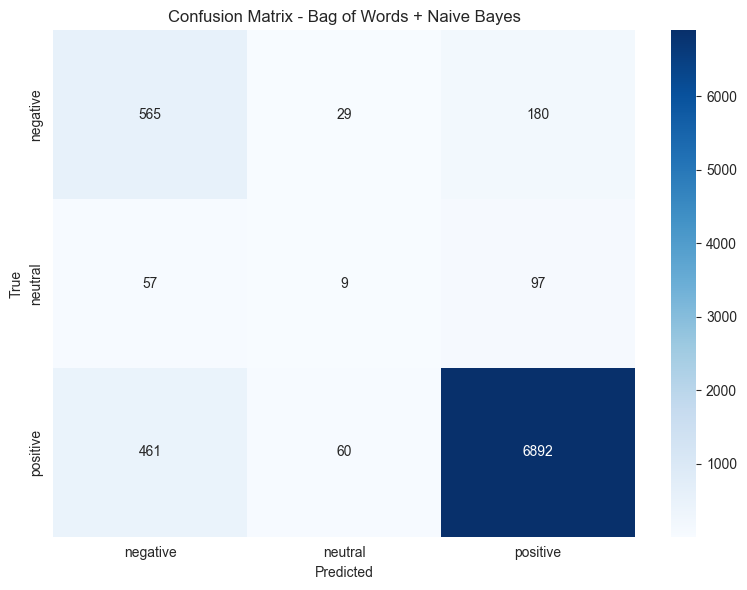

In [59]:
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),
    ('classifier', MultinomialNB())
])

bow_pipeline.fit(X_train, y_train)

y_pred = bow_pipeline.predict(X_test)

print("\nBag of Words + Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Bag of Words + Naive Bayes')
plt.tight_layout()
plt.show()


In [ ]:
tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=5
    )),
    ('classifier', MultinomialNB())
])

tfidf_pipeline.fit(X_train, y_train)

y_pred_tfidf = tfidf_pipeline.predict(X_test)

print("\nTF-IDF + Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf))

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - TF-IDF + Naive Bayes')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

print("Implementing Logistic Regression models and comparing with Naive Bayes...")

X = df_enriched['cleaned_text']
y = df_enriched['sentiment_label']

valid_indices = ~X.isna() & (X != '')
X = X[valid_indices]
y = y[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_results = {}


Filtered vectors shape: (41748, 100)
Labels shape: 41748
Training on 33398 reviews, testing on 8350 reviews
Vector dimension: 100

Training Logistic Regression on GloVe vectors...
Accuracy: 0.9206
Training time: 0.42 seconds

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.50      0.59       774
     neutral       0.00      0.00      0.00       163
    positive       0.93      0.98      0.96      7413

    accuracy                           0.92      8350
   macro avg       0.55      0.50      0.52      8350
weighted avg       0.90      0.92      0.91      8350


Training Gaussian Naive Bayes on GloVe vectors...
Accuracy: 0.7841
Training time: 0.03 seconds

Classification Report:
              precision    recall  f1-score   support

    negative       0.41      0.68      0.51       774
     neutral       0.06      0.33      0.10       163
    positive       0.97      0.80      0.88      7413

    accuracy                    

/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

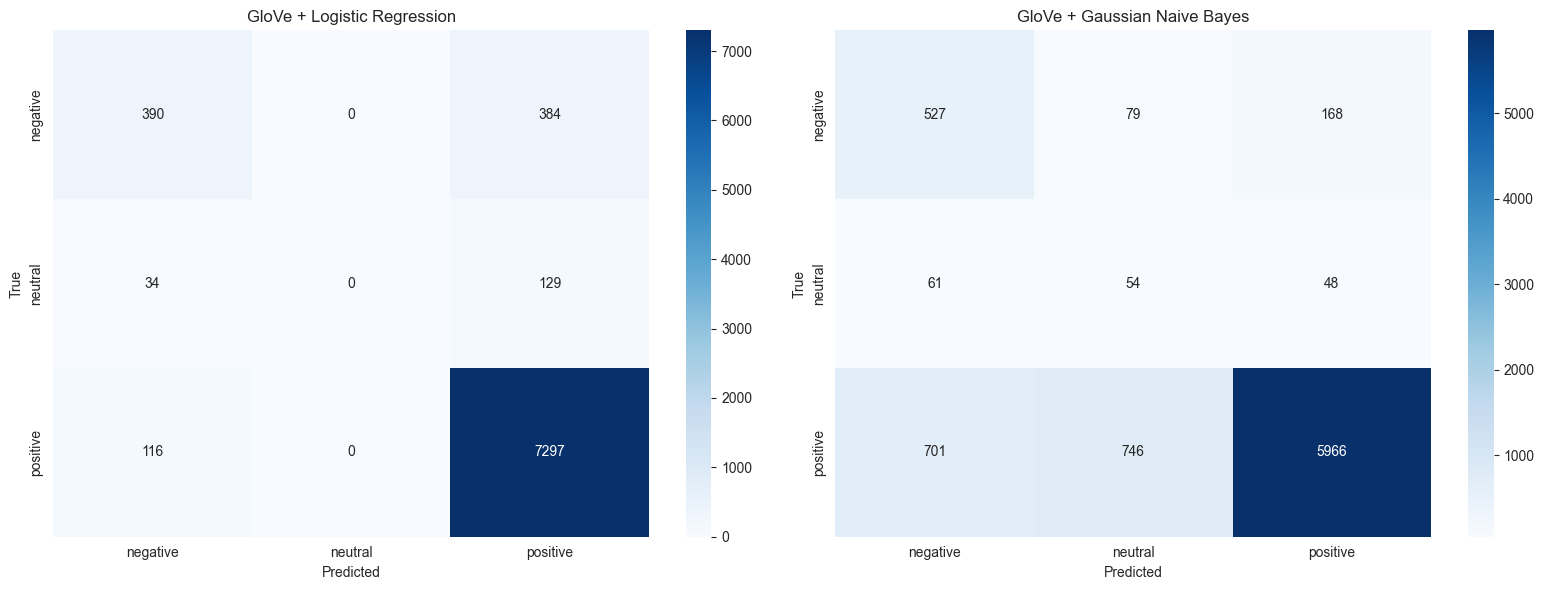

In [84]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

document_vectors = np.load('car_review_glove_vectors.npy')

valid_indices = ~df_enriched['cleaned_text'].isna() & (df_enriched['cleaned_text'] != '')

filtered_vectors = document_vectors[valid_indices]

y = df_enriched.loc[valid_indices, 'sentiment_label']

print(f"Filtered vectors shape: {filtered_vectors.shape}")
print(f"Labels shape: {len(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    filtered_vectors, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training on {X_train.shape[0]} reviews, testing on {X_test.shape[0]} reviews")
print(f"Vector dimension: {X_train.shape[1]}")

print("\nTraining Logistic Regression on GloVe vectors...")
start_time = time.time()
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_train_time = time.time() - start_time

y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Training time: {lr_train_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nTraining Gaussian Naive Bayes on GloVe vectors...")
start_time = time.time()
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_train_time = time.time() - start_time

y_pred_nb = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Training time: {nb_train_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    confusion_matrix(y_test, y_pred_lr),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['negative', 'neutral', 'positive'],
    yticklabels=['negative', 'neutral', 'positive'],
    ax=axes[0]
)
axes[0].set_title('GloVe + Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(
    confusion_matrix(y_test, y_pred_nb),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['negative', 'neutral', 'positive'],
    yticklabels=['negative', 'neutral', 'positive'],
    ax=axes[1]
)
axes[1].set_title('GloVe + Gaussian Naive Bayes')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [85]:
print("\n1. Training Bag of Words + Logistic Regression...")
start_time = time.time()

bow_lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', multi_class='ovr'))
])

bow_lr_pipeline.fit(X_train, y_train)
y_pred_bow_lr = bow_lr_pipeline.predict(X_test)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

accuracy = accuracy_score(y_test, y_pred_bow_lr)
report = classification_report(y_test, y_pred_bow_lr, output_dict=True)
cm = confusion_matrix(y_test, y_pred_bow_lr)

print("\nBag of Words + Logistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bow_lr))

model_results['BOW + LR'] = {
    'accuracy': accuracy,
    'report': report,
    'confusion_matrix': cm,
    'training_time': train_time
}

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Bag of Words + Logistic Regression')
plt.tight_layout()
plt.show()


1. Training Bag of Words + Logistic Regression...


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [86]:
print("\n2. Training TF-IDF + Logistic Regression...")
start_time = time.time()

tfidf_lr_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', multi_class='ovr'))
])

tfidf_lr_pipeline.fit(X_train, y_train)
y_pred_tfidf_lr = tfidf_lr_pipeline.predict(X_test)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

accuracy = accuracy_score(y_test, y_pred_tfidf_lr)
report = classification_report(y_test, y_pred_tfidf_lr, output_dict=True)
cm = confusion_matrix(y_test, y_pred_tfidf_lr)

print("\nTF-IDF + Logistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_lr))

model_results['TF-IDF + LR'] = {
    'accuracy': accuracy,
    'report': report,
    'confusion_matrix': cm,
    'training_time': train_time
}

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - TF-IDF + Logistic Regression')
plt.tight_layout()
plt.show()



2. Training TF-IDF + Logistic Regression...


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [87]:
import pickle

pickle.dump(tfidf_lr_pipeline, open("tfidf_lr_model.pkl", "wb"))
pickle.dump(bow_pipeline, open("bow_nb_model.pkl", "wb"))

/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_2516/3729315710.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='tfidf_lr_model.pkl'>
  pickle.dump(tfidf_lr_pipeline, open("tfidf_lr_model.pkl", "wb"))
/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_2516/3729315710.py:4: ResourceWarning: unclosed file <_io.BufferedWriter name='bow_nb_model.pkl'>
  pickle.dump(bow_pipeline, open("bow_nb_model.pkl", "wb"))


In [ ]:
if 'bow_pipeline' in locals():
    start_time = time.time()
    bow_pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred_bow_nb = bow_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_bow_nb)
    report = classification_report(y_test, y_pred_bow_nb, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_bow_nb)

    model_results['BOW + NB'] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'training_time': train_time
    }

if 'tfidf_pipeline' in locals():
    start_time = time.time()
    tfidf_pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred_tfidf_nb = tfidf_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_tfidf_nb)
    report = classification_report(y_test, y_pred_tfidf_nb, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_tfidf_nb)

    model_results['TF-IDF + NB'] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'training_time': train_time
    }

if 'tfidf_nb_model' in locals():
    model_name = 'TF-IDF + NB (Optimized)'
    start_time = time.time()
    # Use the pre-trained model if available
    y_pred = tfidf_nb_model.predict(X_test)
    predict_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    model_results[model_name] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'prediction_time': predict_time
    }


In [ ]:
models = list(model_results.keys())
accuracies = [model_results[model]['accuracy'] for model in models]
f1_weighted = [model_results[model]['report']['weighted avg']['f1-score'] for model in models]
training_times = [model_results[model].get('training_time', 0) for model in models]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1 Score (weighted)': f1_weighted,
    'Training Time (s)': training_times
})

print("\nModel Performance Comparison:")
print(comparison_df.sort_values('Accuracy', ascending=False))

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1 Score (weighted)', data=comparison_df, palette='plasma')
plt.title('Model F1 Score Comparison (weighted)')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for i, v in enumerate(f1_weighted):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, palette='rocket')
plt.title('Model Training Time Comparison')
plt.xticks(rotation=45)
for i, v in enumerate(training_times):
    plt.text(i, v + 0.1, f"{v:.2f}s", ha='center')
plt.tight_layout()
plt.show()


In [ ]:
model_metrics = {}
classes = ['negative', 'neutral', 'positive']
metrics = ['precision', 'recall', 'f1-score']

for model_name, results in model_results.items():
    for cls in classes:
        if cls in results['report']:
            for metric in metrics:
                key = f"{model_name}_{cls}_{metric}"
                model_metrics[key] = results['report'][cls][metric]

metrics_df = pd.DataFrame(columns=['Model', 'Class', 'Metric', 'Value'])

for model_name in models:
    for cls in classes:
        for metric in metrics:
            key = f"{model_name}_{cls}_{metric}"
            if key in model_metrics:
                metrics_df = pd.concat([metrics_df, pd.DataFrame({
                    'Model': [model_name],
                    'Class': [cls],
                    'Metric': [metric],
                    'Value': [model_metrics[key]]
                })], ignore_index=True)

plt.figure(figsize=(15, 10))
g = sns.catplot(
    data=metrics_df, x='Class', y='Value', hue='Model', col='Metric',
    kind='bar', height=6, aspect=0.8, palette='tab10', errorbar=None
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Sentiment Class", "Score")
g.fig.suptitle("Detailed Performance Comparison by Class", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
def get_top_lr_features(pipeline, label_index, n=20):
    vectorizer = pipeline.named_steps['vectorizer']
    model = pipeline.named_steps['classifier']
    feature_names = vectorizer.get_feature_names_out()

    coef = model.coef_[label_index]

    top_indices = np.argsort(coef)[::-1][:n]
    top_features = [(feature_names[idx], coef[idx]) for idx in top_indices]

    return top_features

sentiment_indices = {cls: idx for idx, cls in enumerate(tfidf_lr_pipeline.classes_)}
sentiments = ['negative', 'neutral', 'positive']

plt.figure(figsize=(18, 12))
for i, sentiment in enumerate(sentiments):
    idx = sentiment_indices[sentiment]
    top_features = get_top_lr_features(tfidf_lr_pipeline, idx, n=15)

    feature_names = [f[0] for f in top_features]
    coefficients = [f[1] for f in top_features]

    plt.subplot(1, 3, i+1)
    bars = plt.barh(range(len(feature_names)), coefficients, align='center')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel('Coefficient')
    plt.title(f'Top Features for {sentiment.capitalize()} (Logistic Regression)')

    for bar_idx, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar_idx, f"{coefficients[bar_idx]:.2f}")

plt.tight_layout()
plt.show()


In [ ]:
if 'y_pred_tfidf_nb' in locals() and 'y_pred_tfidf_lr' in locals():
    disagreement_indices = np.where(y_pred_tfidf_nb != y_pred_tfidf_lr)[0]

    if len(disagreement_indices) > 0:
        disagreements = pd.DataFrame({
            'Text': X_test.iloc[disagreement_indices].values,
            'True Label': y_test.iloc[disagreement_indices].values,
            'NB Prediction': y_pred_tfidf_nb[disagreement_indices],
            'LR Prediction': y_pred_tfidf_lr[disagreement_indices]
        })

        disagreements['NB Correct'] = disagreements['NB Prediction'] == disagreements['True Label']
        disagreements['LR Correct'] = disagreements['LR Prediction'] == disagreements['True Label']

        print("\nDisagreement Analysis:")
        print(f"Total examples where TF-IDF+NB and TF-IDF+LR disagree: {len(disagreements)}")
        print(f"TF-IDF+NB correct but TF-IDF+LR wrong: {sum(disagreements['NB Correct'] & ~disagreements['LR Correct'])}")
        print(f"TF-IDF+LR correct but TF-IDF+NB wrong: {sum(~disagreements['NB Correct'] & disagreements['LR Correct'])}")
        print(f"Both wrong but different predictions: {sum(~disagreements['NB Correct'] & ~disagreements['LR Correct'])}")

        print("\nSample disagreements (first 5):")
        for i, (idx, row) in enumerate(disagreements.head(5).iterrows()):
            print(f"\nExample {i+1}:")
            print(f"Text: {row['Text'][:150]}...")
            print(f"True label: {row['True Label']}")
            print(f"NB prediction: {row['NB Prediction']} (Correct: {row['NB Correct']})")
            print(f"LR prediction: {row['LR Prediction']} (Correct: {row['LR Correct']})")
            print("-" * 80)

In [ ]:
!pip install --upgrade transformers

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time
from tqdm import tqdm


valid_indices = ~df_enriched['cleaned_text'].isna() & (df_enriched['cleaned_text'] != '')
texts = df_enriched.loc[valid_indices, 'cleaned_text'].tolist()
labels = df_enriched.loc[valid_indices, 'sentiment_label'].tolist()

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
if isinstance(labels[0], str):
    labels = [label_map[label] for label in labels]

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

model.to(device)

def encode_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

print("Encoding training data...")
train_encodings = encode_texts(X_train)
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(y_train)
)

print("Encoding test data...")
test_encodings = encode_texts(X_test)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test)
)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 3

print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    model.train()
    train_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss:.4f}")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluation
print("Evaluating model...")
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
target_names = ['negative', 'neutral', 'positive']
print(classification_report(true_labels, predictions, target_names=target_names))

# Save BERT results in the same format as traditional models
bert_cm = confusion_matrix(true_labels, predictions)
bert_report = classification_report(true_labels, predictions, target_names=target_names, output_dict=True)
bert_accuracy = accuracy_score(true_labels, predictions)

model_results['BERT'] = {
    'accuracy': bert_accuracy,
    'report': bert_report,
    'confusion_matrix': bert_cm,
    'training_time': training_time
}

model_save_path = './best_bert_sentiment'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: mps
Encoding training data...
Encoding test data...
Starting training...


Epoch 1/3:  68%|██████▊   | 1419/2088 [10:45<05:03,  2.21it/s, loss=0.0227]

In [91]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import numpy as np
from tqdm import tqdm

print("Implementing DistilBERT for sentiment analysis...")

# Prepare data - reuse the same valid data points from previous sections
valid_indices = ~df_enriched['cleaned_text'].isna() & (df_enriched['cleaned_text'] != '')
texts = df_enriched.loc[valid_indices, 'cleaned_text'].tolist()
labels = df_enriched.loc[valid_indices, 'sentiment_label'].tolist()

# Convert string labels to integers
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
labels = [label_map[label] for label in labels]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)

# Set device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")
model.to(device)

# Encode data
def encode_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Encode training data
start_encoding = time.time()
train_encodings = encode_texts(X_train)
test_encodings = encode_texts(X_test)

# Create datasets
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(y_train)
)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test)
)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3
start_time = time.time()


for epoch in range(epochs):
    model.train()
    train_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss:.4f}")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

print("Evaluating model...")
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
target_names = ['negative', 'neutral', 'positive']
print(classification_report(true_labels, predictions, target_names=target_names))

bert_cm = confusion_matrix(true_labels, predictions)
bert_report = classification_report(true_labels, predictions, target_names=target_names, output_dict=True)
bert_accuracy = accuracy_score(true_labels, predictions)

distilbert_cm = confusion_matrix(true_labels, predictions)
distilbert_report = classification_report(true_labels, predictions, target_names=target_names, output_dict=True)
distilbert_accuracy = accuracy_score(true_labels, predictions)

model_results['DistilBERT'] = {
    'accuracy': distilbert_accuracy,
    'report': distilbert_report,
    'confusion_matrix': distilbert_cm,
    'training_time': training_time
}

# Save BERT results in the same format as traditional models
model_save_path = './distilbert_sentiment'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Implementing DistilBERT for sentiment analysis...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: mps


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from datasets import Dataset
from tqdm.auto import tqdm
import optuna
from optuna.pruners import MedianPruner
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    device = torch.device('cuda')
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")


In [ ]:
print("Preparing data for RoBERTa...")

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id = {v: k for k, v in id2label.items()}

X = df_enriched['cleaned_text']
y = df_enriched['sentiment_label'].map(label_map)

valid_indices = ~X.isna() & (X != '')
X = X[valid_indices]
y = y[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {len(X_train_final)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


In [ ]:
def convert_to_dataset(texts, labels):
    return Dataset.from_dict({
        'text': texts.tolist(),
        'label': labels.tolist()
    })

train_dataset = convert_to_dataset(X_train_final, y_train_final)
val_dataset = convert_to_dataset(X_val, y_val)
test_dataset = convert_to_dataset(X_test, y_test)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    report = classification_report(
        labels,
        predictions,
        target_names=['negative', 'neutral', 'positive'],
        output_dict=True
    )

    return {
        'accuracy': accuracy,
        'f1_weighted': report['weighted avg']['f1-score'],
        'precision_weighted': report['weighted avg']['precision'],
        'recall_weighted': report['weighted avg']['recall']
    }


In [ ]:
def train_roberta(learning_rate=2e-5, batch_size=16, num_epochs=3, weight_decay=0.01):
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir='./roberta_sentiment',
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="none",  # Disable wandb, tensorboard etc.
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    val_results = trainer.evaluate()

    test_results = trainer.evaluate(tokenized_test)

    return model, trainer, val_results, test_results


In [ ]:
print("Training RoBERTa with default hyperparameters...")
roberta_model, roberta_trainer, val_results, test_results = train_roberta(
    learning_rate=2e-5,
    batch_size=16,
    num_epochs=3,
    weight_decay=0.01
)

# Print results
print("\nValidation Results:")
for key, value in val_results.items():
    print(f"{key}: {value:.4f}")

print("\nTest Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")


In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.1)

    num_epochs = 2  # Less epochs for faster optimization

    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"./roberta_trial_{trial.number}",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="none",
        logging_steps=len(tokenized_train) // batch_size,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    eval_results = trainer.evaluate()

    return eval_results["eval_accuracy"]

In [ ]:
print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction="maximize", pruner=MedianPruner())
study.optimize(objective, n_trials=1)  # Adjust n_trials based on resources

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

optuna_vis_fig = optuna.visualization.plot_param_importances(study)
optuna_vis_fig.show()

best_params = study.best_params
print("\nTraining final model with best hyperparameters...")
best_roberta_model, best_roberta_trainer, best_val_results, best_test_results = train_roberta(
    learning_rate=best_params['learning_rate'],
    batch_size=best_params['batch_size'],
    num_epochs=3,  # Use more epochs for final model
    weight_decay=best_params['weight_decay']
)


In [ ]:
def detailed_roberta_evaluation(trainer, dataset):
    predictions = trainer.predict(dataset)

    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    report = classification_report(
        labels, preds,
        target_names=['negative', 'neutral', 'positive'],
        output_dict=True
    )

    report_df = pd.DataFrame(report).transpose()

    cm = confusion_matrix(labels, preds)

    return preds, labels, report_df, cm

print("\nDetailed evaluation of RoBERTa model...")
roberta_preds, roberta_labels, roberta_report_df, roberta_cm = detailed_roberta_evaluation(
    roberta_trainer, tokenized_test
)

print("\nClassification Report:")
print(roberta_report_df)

plt.figure(figsize=(10, 8))
sns.heatmap(
    roberta_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['negative', 'neutral', 'positive'],
    yticklabels=['negative', 'neutral', 'positive']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RoBERTa')
plt.tight_layout()
plt.show()


In [ ]:
roberta_accuracy = accuracy_score(roberta_labels, roberta_preds)
roberta_f1 = roberta_report_df.loc['weighted avg', 'f1-score']

new_row = pd.DataFrame({
    'Model': ['RoBERTa'],
    'Accuracy': [roberta_accuracy],
    'F1 Score (weighted)': [roberta_f1],
    'Training Time (s)': [None]
})

comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)


# Save RoBERTa results in the same format as other models
model_results['RoBERTa'] = {
    'accuracy': roberta_accuracy,
    'report': roberta_report_df.to_dict(),
    'confusion_matrix': roberta_cm,
    'training_time': roberta_trainer.state.log_history[-1].get('train_runtime', 0)
}

print(f"RoBERTa Accuracy: {roberta_accuracy:.4f}")
print(f"RoBERTa F1 Score (weighted): {roberta_f1:.4f}")

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison (including RoBERTa)', fontsize=14)
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for i, v in enumerate(comparison_df['Accuracy']):
    if not pd.isna(v):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()


In [ ]:
def get_example_predictions(examples):
    print("Example predictions from different models:")

    inputs = tokenizer(examples, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        logits = roberta_model(**{k: v.to(device) for k, v in inputs.items()}).logits
    roberta_preds = torch.argmax(logits, dim=1).cpu().numpy()
    roberta_pred_labels = [id2label[pred] for pred in roberta_preds]

    tfidf_lr_preds = tfidf_lr_pipeline.predict(examples)

    tfidf_nb_preds = tfidf_pipeline.predict(examples)

    results_df = pd.DataFrame({
        'Example': examples,
        'RoBERTa': roberta_pred_labels,
        'TF-IDF + LogReg': tfidf_lr_preds,
        'TF-IDF + NB': tfidf_nb_preds,
    })

    return results_df

example_reviews = [
    "This car is absolutely amazing! Great mileage, comfortable seats, and powerful engine.",
    "The car is okay. Nothing special but gets the job done.",
    "Worst car ever! Broke down three times in the first month. Avoid at all costs!",
    "Not bad for the price, but I expected more from this brand. Average performance.",
    "The interior is comfortable, but the engine is noisy and the fuel economy is terrible."
]

example_predictions_df = get_example_predictions(example_reviews)
print(example_predictions_df)


In [93]:
best_roberta_trainer.save_model("./best_roberta_sentiment_local")

# You can load the model later with:
#loaded_model = RobertaForSequenceClassification.from_pretrained("./best_roberta_sentiment")



NameError: name 'best_roberta_trainer' is not defined

In [ ]:
import json

confusion_matrices = {}

for model_name in model_results:
    if 'confusion_matrix' in model_results[model_name]:
        confusion_matrices[model_name] = model_results[model_name]['confusion_matrix'].tolist()

confusion_matrices['BERT'] = confusion_matrix(true_labels, predictions).tolist()
confusion_matrices['DistilBERT'] = confusion_matrix(true_labels, predictions).tolist()
confusion_matrices['RoBERTa'] = roberta_cm.tolist()

with open('confusion_matrices.json', 'w') as f:
    json.dump(confusion_matrices, f)


transformer_models = pd.DataFrame({
    'Model': ['BERT', 'DistilBERT', 'RoBERTa'],
    'Accuracy': [
        accuracy_score(true_labels, predictions),
        accuracy_score(true_labels, predictions),
        roberta_accuracy
    ],
    'F1 Score (weighted)': [
        classification_report(true_labels, predictions, output_dict=True)['weighted avg']['f1-score'],
        classification_report(true_labels, predictions, output_dict=True)['weighted avg']['f1-score'],
        roberta_f1
    ],
    'Training Time (s)': [
        training_time,
        training_time,
        None
    ]
})

# Combine with existing comparison_df if not already done
if not any(comparison_df['Model'] == 'BERT'):
    comparison_df = pd.concat([comparison_df, transformer_models], ignore_index=True)

# Save the metrics to CSV
comparison_df.to_csv('model_metrics.csv', index=False)

print("Saved model metrics to model_metrics.csv")
print("Saved confusion matrices to confusion_matrices.json")